In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import scipy
import spacy
from collections import Counter
%matplotlib inline
sns.set_style("darkgrid")
colors = ['#651FFF', '#00B0FF', '#1DE9B6', '#00E676', '#FF9100', '#FF3D00']
sns.set_palette(colors)

## Introduction

For this exercise we'll be using New York City bus dat

In [2]:
bus = pd.read_csv('data/mta_1710.csv', low_memory=False, usecols=['RecordedAtTime','DirectionRef','PublishedLineName','OriginName','OriginLat','OriginLong','DestinationName','DestinationLat','DestinationLong','VehicleRef','VehicleLocation.Latitude','VehicleLocation.Longitude',
                                                          'NextStopPointName','ArrivalProximityText','DistanceFromStop','ExpectedArrivalTime','ScheduledArrivalTime'])
#bus2 = pd.read_csv('data/mta_1708.csv', low_memory=False)
bus.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime
0,2017-10-01 00:03:31,0,M60-SBS,BROADWAY/W 106 ST,40.801818,-73.967642,SELECT BUS SERVICE LA GUARDIA AIRPORT,40.768074,-73.862089,NYCT_5846,40.809715,-73.960110,AMSTERDAM AV/W 120 ST,approaching,122,2017-10-01 00:04:06,24:05:28
1,2017-10-01 00:03:32,0,Q58,PALMETTO ST/MYRTLE AV,40.700178,-73.910254,FLUSHING MAIN ST,40.757344,-73.829362,NYCT_3967,40.742271,-73.854411,108 ST/OTIS AV,approaching,131,2017-10-01 00:04:03,23:33:09
2,2017-10-01 00:03:29,0,M15,SOUTH ST/WHITEHALL ST,40.701536,-74.012485,EAST HARLEM 125 ST via 1 AV,40.803150,-73.932264,NYCT_5912,40.770211,-73.954244,1 AV/E 77 ST,approaching,135,2017-10-01 00:04:03,23:51:06
3,2017-10-01 00:03:24,1,S78,ST GEORGE FERRY/S78,40.643655,-74.073470,BRICKTOWN MALL,40.530061,-74.226654,NYCT_8180,40.643197,-74.074438,BAY ST/NICK LAPORTE PL,< 1 stop away,205,2017-10-01 00:03:55,24:00:44
4,2017-10-01 00:03:22,0,B6,HARWAY AV/BAY 37 ST,40.593510,-73.993996,EAST NY NEW LOTS STA,40.666420,-73.883387,NYCT_5110,40.633909,-73.918793,FLATLANDS AV/RALPH AV,< 1 stop away,271,2017-10-01 00:04:21,23:47:00


In [3]:
bus.shape

(6865841, 17)

In [4]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6865841 entries, 0 to 6865840
Data columns (total 17 columns):
RecordedAtTime               object
DirectionRef                 int64
PublishedLineName            object
OriginName                   object
OriginLat                    float64
OriginLong                   float64
DestinationName              object
DestinationLat               float64
DestinationLong              float64
VehicleRef                   object
VehicleLocation.Latitude     float64
VehicleLocation.Longitude    float64
NextStopPointName            object
ArrivalProximityText         object
DistanceFromStop             object
ExpectedArrivalTime          object
ScheduledArrivalTime         object
dtypes: float64(6), int64(1), object(10)
memory usage: 890.5+ MB


In [5]:
nullvals = pd.DataFrame(bus.isna().sum())
nullvals

,0
RecordedAtTime,0
DirectionRef,0
PublishedLineName,0
OriginName,63445
OriginLat,63445
OriginLong,63445
DestinationName,0
DestinationLat,10369
DestinationLong,10369
VehicleRef,0


In [6]:
bus = bus.dropna()

In [7]:
bus.shape

(5715166, 17)

In [8]:
bus['RecordedAtDateTime'] = pd.to_datetime(bus['RecordedAtTime'])

In [9]:
bus['day_of_week'] = bus['RecordedAtDateTime'].dt.dayofweek

In [10]:
bus['RecordedAtTime'] = bus['RecordedAtDateTime'].dt.time

In [11]:
bus['date'] = bus['RecordedAtDateTime'].dt.date

In [12]:
bus.head(2)

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,VehicleLocation.Latitude,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,RecordedAtDateTime,day_of_week,date
0,00:03:31,0,M60-SBS,BROADWAY/W 106 ST,40.801818,-73.967642,SELECT BUS SERVICE LA GUARDIA AIRPORT,40.768074,-73.862089,NYCT_5846,40.809715,-73.960110,AMSTERDAM AV/W 120 ST,approaching,122,2017-10-01 00:04:06,24:05:28,2017-10-01 00:03:31,6,2017-10-01
1,00:03:32,0,Q58,PALMETTO ST/MYRTLE AV,40.700178,-73.910254,FLUSHING MAIN ST,40.757344,-73.829362,NYCT_3967,40.742271,-73.854411,108 ST/OTIS AV,approaching,131,2017-10-01 00:04:03,23:33:09,2017-10-01 00:03:32,6,2017-10-01


In [13]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5715166 entries, 0 to 6865840
Data columns (total 20 columns):
RecordedAtTime               object
DirectionRef                 int64
PublishedLineName            object
OriginName                   object
OriginLat                    float64
OriginLong                   float64
DestinationName              object
DestinationLat               float64
DestinationLong              float64
VehicleRef                   object
VehicleLocation.Latitude     float64
VehicleLocation.Longitude    float64
NextStopPointName            object
ArrivalProximityText         object
DistanceFromStop             object
ExpectedArrivalTime          object
ScheduledArrivalTime         object
RecordedAtDateTime           datetime64[ns]
day_of_week                  int64
date                         object
dtypes: datetime64[ns](1), float64(6), int64(2), object(11)
memory usage: 915.7+ MB


In [14]:
# DONT RUN THIS TWICE, WILL BREAK THE TIME
bus['ExpectedArrivalTime'] = pd.to_datetime(bus['ExpectedArrivalTime'], errors='coerce', utc=True)
bus['ExpectedArrivalTime'].head()

bus['ExpectedArrivalTime'] = pd.to_datetime(bus['ExpectedArrivalTime'], errors='coerce', utc=True)
sch_hours = pd.DataFrame()
sch_hours['hour'] = bus['ExpectedArrivalTime'].dt.hour
sch_hours['min'] = bus['ExpectedArrivalTime'].dt.minute

sch_hours['time'] = sch_hours['hour'].astype(str).str.cat(sch_hours['min'].astype(str))
sch_hours['time'] = sch_hours['time'].str.replace('.0','')
sch_hours['time'] = pd.to_numeric(sch_hours['time'], errors='coerce')

In [15]:
bus['ExpectedArrivalTime'] = sch_hours['time']

In [16]:
# DONT RUN THIS TWICE, WILL BREAK THE TIME
bus['ScheduledArrivalTime'] = pd.to_datetime(bus['ScheduledArrivalTime'], errors='coerce', utc=True)
sch_hours2 = pd.DataFrame()
sch_hours2['hour'] = bus['ScheduledArrivalTime'].dt.hour
sch_hours2['min'] = bus['ScheduledArrivalTime'].dt.minute

sch_hours2['time'] = sch_hours2['hour'].astype(str).str.cat(sch_hours2['min'].astype(str))
sch_hours2['time'] = sch_hours2['time'].str.replace('.0','')
sch_hours2['time'] = pd.to_numeric(sch_hours2['time'], errors='coerce')

In [17]:
bus['ScheduledArrivalTime'] = sch_hours2['time']

In [18]:
# DONT RUN THIS TWICE, WILL BREAK THE TIME
rec_hours = pd.DataFrame()
rec_hours['hour'] = bus['RecordedAtDateTime'].dt.hour
rec_hours['min'] = bus['RecordedAtDateTime'].dt.minute

rec_hours['time'] = rec_hours['hour'].astype(str).str.cat(rec_hours['min'].astype(str))
rec_hours['time'] = rec_hours['time'].str.replace('.0','')
rec_hours['time'] = pd.to_numeric(rec_hours['time'], errors='coerce')

In [19]:
bus['RecordedAtTime'] = rec_hours['time']

In [20]:
bus[['RecordedAtDateTime','RecordedAtTime','ScheduledArrivalTime','ExpectedArrivalTime']].tail(10)

,RecordedAtDateTime,RecordedAtTime,ScheduledArrivalTime,ExpectedArrivalTime
6865831,2017-10-31 23:58:58,2358.0,2349.0,2359.0
6865832,2017-10-31 23:58:49,2358.0,2359.0,2359.0
6865833,2017-10-31 23:58:44,2358.0,2355.0,2359.0
6865834,2017-10-31 23:58:37,2358.0,2354.0,2358.0
6865835,2017-10-31 23:58:41,2358.0,2341.0,2358.0
6865836,2017-10-31 23:58:47,2358.0,2349.0,2.0
6865837,2017-10-31 23:58:30,2358.0,2359.0,2.0
6865838,2017-10-31 23:58:49,2358.0,NaN,2359.0
6865839,2017-10-31 23:58:30,2358.0,2343.0,2359.0
6865840,2017-10-31 23:58:44,2358.0,NaN,2359.0


In [21]:
bus = bus.dropna()
bus['delay'] = bus['ScheduledArrivalTime'] - bus['ExpectedArrivalTime']

bus[['ScheduledArrivalTime', 'ExpectedArrivalTime', 'delay']].head(10)

,ScheduledArrivalTime,ExpectedArrivalTime,delay
1,2333.0,4.0,2329.0
2,2351.0,4.0,2347.0
4,2347.0,4.0,2343.0
6,2334.0,4.0,2330.0
9,2353.0,4.0,2349.0
11,2336.0,3.0,2333.0
13,2359.0,4.0,2355.0
14,2319.0,4.0,2315.0
15,2349.0,3.0,2346.0
16,2346.0,3.0,2343.0


In [22]:
bus.delay.loc[bus.delay>120] = 2360 - bus.delay.loc[bus.delay>120]

bus[['ScheduledArrivalTime', 'ExpectedArrivalTime', 'delay']].head(20)

/usr/local/lib/python3.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,ScheduledArrivalTime,ExpectedArrivalTime,delay
1,2333.0,4.0,31.0
2,2351.0,4.0,13.0
4,2347.0,4.0,17.0
6,2334.0,4.0,30.0
9,2353.0,4.0,11.0
11,2336.0,3.0,27.0
13,2359.0,4.0,5.0
14,2319.0,4.0,45.0
15,2349.0,3.0,14.0
16,2346.0,3.0,17.0


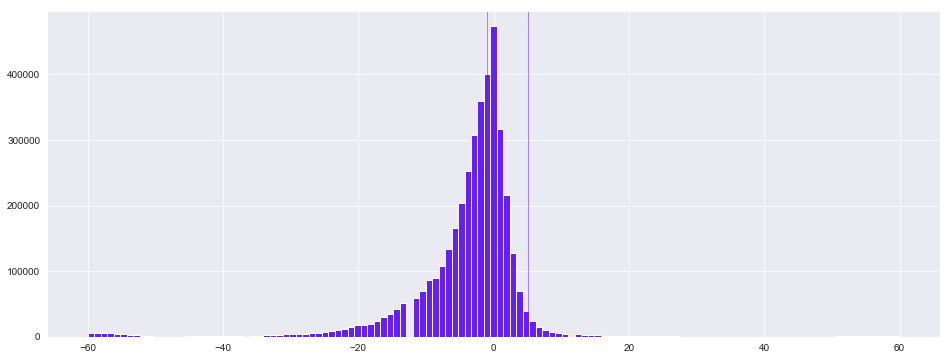

In [23]:
#bus.delay.loc[bus.delay<-120] = 2360 + bus.delay.loc[bus.delay<-120]
bus = bus.drop(bus[bus['delay']>60].index)
bus = bus.drop(bus[bus['delay']<-60].index)
plt.figure(figsize=(16,6))
plt.hist(bus['delay'], bins=125)
plt.axvline(x=5, linewidth=.5)
plt.axvline(x=-1, linewidth=.5)
plt.show()

In [24]:
bus.loc[bus.delay<-10].head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,VehicleLocation.Longitude,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,RecordedAtDateTime,day_of_week,date,delay
1161,13.0,0,M14D,11 AV/W 17 ST,40.744841,-74.008147,LOWER E. SIDE DELANCY-FDR CROSSTOWN,40.716391,-73.980131,NYCT_5289,...,-74.006675,W 18 ST / 10 AV,approaching,78,13.0,0.0,2017-10-01 00:13:32,6,2017-10-01,-13.0
1162,13.0,0,M14D,11 AV/W 17 ST,40.744841,-74.008147,LOWER E. SIDE DELANCY-FDR CROSSTOWN,40.716391,-73.980131,NYCT_5289,...,-74.006675,W 18 ST / 10 AV,approaching,78,13.0,0.0,2017-10-01 00:13:32,6,2017-10-01,-13.0
1201,13.0,1,M15,E 126 ST/2 AV,40.803230,-73.932451,SOUTH FERRY via 2 AV,40.701609,-74.012226,NYCT_6041,...,-73.932604,2 AV/E 125 ST,< 1 stop away,169,13.0,0.0,2017-10-01 00:13:39,6,2017-10-01,-13.0
1584,24.0,1,B60,WASHINGTON PLZ/LANE 2,40.709517,-73.959497,CANARSIE WILLIAMS AV,40.650239,-73.891686,NYCT_3993,...,-73.939809,JOHNSON AV/BUSHWICK AV,approaching,119,25.0,0.0,2017-10-01 00:24:05,6,2017-10-01,-25.0
1587,24.0,1,Bx27,MORRISON AV/WESTCHESTER AV,40.829097,-73.874570,CLASON PT,40.807544,-73.852337,NYCT_315,...,-73.852288,SOUNDVIEW AV/CORNELL AV,at stop,0,24.0,13.0,2017-10-01 00:24:03,6,2017-10-01,-11.0


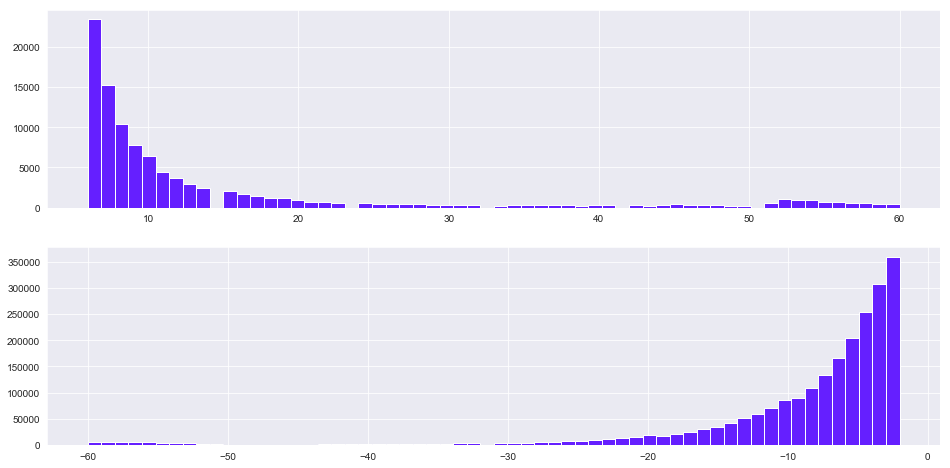

In [25]:
plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
bus.delay.loc[bus.delay>5].hist(bins=60)
plt.subplot(2,1,2)
bus.delay.loc[bus.delay<-1].hist(bins=60)
plt.show()

## Create the binary variable
According to this document, an on-time bus is defined as either more than 1 minute early and 5 minutes late.  https://docs.google.com/spreadsheets/d/1WqLV3EeCMOZwi0oZdYICkuvN86N0S4QGTMvbhS8UU0E/edit#gid=0

In [26]:
# https://docs.google.com/spreadsheets/d/1WqLV3EeCMOZwi0oZdYICkuvN86N0S4QGTMvbhS8UU0E/edit#gid=0
bus['on_time'] = np.where((bus['delay'] > 5) | (bus['delay'] < -1), 0, 1)
bus.head(3)

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,NextStopPointName,ArrivalProximityText,DistanceFromStop,ExpectedArrivalTime,ScheduledArrivalTime,RecordedAtDateTime,day_of_week,date,delay,on_time
1,3.0,0,Q58,PALMETTO ST/MYRTLE AV,40.700178,-73.910254,FLUSHING MAIN ST,40.757344,-73.829362,NYCT_3967,...,108 ST/OTIS AV,approaching,131,4.0,2333.0,2017-10-01 00:03:32,6,2017-10-01,31.0,0
2,3.0,0,M15,SOUTH ST/WHITEHALL ST,40.701536,-74.012485,EAST HARLEM 125 ST via 1 AV,40.803150,-73.932264,NYCT_5912,...,1 AV/E 77 ST,approaching,135,4.0,2351.0,2017-10-01 00:03:29,6,2017-10-01,13.0,0
4,3.0,0,B6,HARWAY AV/BAY 37 ST,40.593510,-73.993996,EAST NY NEW LOTS STA,40.666420,-73.883387,NYCT_5110,...,FLATLANDS AV/RALPH AV,< 1 stop away,271,4.0,2347.0,2017-10-01 00:03:22,6,2017-10-01,17.0,0


## Balance the Data

In [27]:
compare = pd.DataFrame()

compare['On Time'] = bus.on_time.loc[bus['on_time']==1].describe()
compare['Not On Time'] = bus.on_time.loc[bus['on_time']==0].describe()

compare

,On Time,Not On Time
count,1644271.0,2320052.0
mean,1.0,0.0
std,0.0,0.0
min,1.0,0.0
25%,1.0,0.0
50%,1.0,0.0
75%,1.0,0.0
max,1.0,0.0


In [28]:
bus_s = bus.sample(frac=1, random_state=1)

ontime = bus_s.loc[bus['on_time']==1][:500000]
offtime = bus_s.loc[bus['on_time']==0][:500000]

bus = pd.concat([ontime, offtime])
bus = bus.sample(frac=1, random_state=40)

compare['On Time'] = bus.on_time.loc[bus['on_time']==1].describe()
compare['Not On Time'] = bus.on_time.loc[bus['on_time']==0].describe()
compare

,On Time,Not On Time
count,500000.0,500000.0
mean,1.0,0.0
std,0.0,0.0
min,1.0,0.0
25%,1.0,0.0
50%,1.0,0.0
75%,1.0,0.0
max,1.0,0.0


In [29]:
bus['PublishedLineName'].head(10)

3006460         Bx9
1154973         B35
924544     Bx41-SBS
203241          S76
1770957         B26
550370         M100
6327543         B15
1411468     M86-SBS
328433          Q12
34250           B68
Name: PublishedLineName, dtype: object

In [30]:
bronx = bus['PublishedLineName'].str.startswith('Bx')
manhattan = bus['PublishedLineName'].str.contains('M')
brooklyn = bus['PublishedLineName'].str.startswith('B')
queens = bus['PublishedLineName'].str.startswith('Q')
staten = bus['PublishedLineName'].str.startswith('S')
express = bus['PublishedLineName'].str.startswith('X')
select = bus['PublishedLineName'].str.contains('SBS')

In [31]:
bus['boro'] = np.where(bronx, '2 - bronx',
                       np.where(manhattan, '3 - manhattan',
                                np.where(brooklyn, '1 - brooklyn',
                                         np.where(queens, '4 - queens',
                                                  np.where(staten, '5 - staten island',
                                                           np.where(express, 'x-express',
                                                           bus['PublishedLineName'].str.replace('-', ' ')))))))
#bus['boro'] = bus['boro'].astype('category')

In [32]:
bus['boro'] = bus['boro'].astype('category')
dict(enumerate(bus['boro'].cat.categories))

{0: '1 - brooklyn',
 1: '2 - bronx',
 2: '3 - manhattan',
 3: '4 - queens',
 4: '5 - staten island',
 5: 'x-express'}

In [33]:
bus['boro_code'] = bus['boro'].cat.codes

In [34]:
bus['express'] = np.where(express, 1, 0)
bus['sbs'] = np.where(select, 1, 0)
bus.head(2)

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,ScheduledArrivalTime,RecordedAtDateTime,day_of_week,date,delay,on_time,boro,boro_code,express,sbs
3006460,1351.0,0,Bx9,E TREMONT AV/E 177 ST,40.839994,-73.879938,RIVERDALE 262 ST,40.910081,-73.896495,NYCT_5696,...,1324.0,2017-10-14 13:51:51,5,2017-10-14,-30.0,0,2 - bronx,1,0,0
1154973,426.0,1,B35,HEGEMAN AV/CHESTER AV,40.656215,-73.908149,SUNSET PARK 1 AV via CHURCH,40.656499,-74.012109,NYCT_395,...,422.0,2017-10-06 04:26:30,4,2017-10-06,-5.0,0,1 - brooklyn,0,0,0


In [35]:
bus['PublishedLineName'] = bus['PublishedLineName'].astype('category')
bus['bus_code'] = bus['PublishedLineName'].cat.codes
bus_codes = dict(enumerate(bus['PublishedLineName'].cat.categories))

In [36]:
avgdelays = pd.DataFrame(bus.groupby('bus_code')['delay'].mean().sort_values(ascending=False))
avgdelays.columns = ['line_avg_delay']
#avgdelays['FlightNum'] = avgdelays.index

bus = bus.merge(avgdelays, on='bus_code', how='inner')
bus.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,day_of_week,date,delay,on_time,boro,boro_code,express,sbs,bus_code,line_avg_delay
0,1351.0,0,Bx9,E TREMONT AV/E 177 ST,40.839994,-73.879938,RIVERDALE 262 ST,40.910081,-73.896495,NYCT_5696,...,5,2017-10-14,-30.0,0,2 - bronx,1,0,0,96,-2.321765
1,1754.0,1,Bx9,BROADWAY/W 262 ST,40.910104,-73.896730,WEST FARMS,40.840642,-73.879807,NYCT_1208,...,4,2017-10-20,-12.0,0,2 - bronx,1,0,0,96,-2.321765
2,16.0,0,Bx9,E TREMONT AV/E 177 ST,40.839994,-73.879938,RIVERDALE 262 ST,40.910081,-73.896495,NYCT_4731,...,0,2017-10-02,-14.0,0,2 - bronx,1,0,0,96,-2.321765
3,858.0,0,Bx9,E TREMONT AV/E 177 ST,40.839994,-73.879938,RIVERDALE 262 ST,40.910081,-73.896495,NYCT_4749,...,1,2017-10-03,1.0,1,2 - bronx,1,0,0,96,-2.321765
4,1536.0,1,Bx9,BROADWAY/W 262 ST,40.910104,-73.896730,WEST FARMS,40.840642,-73.879807,NYCT_4720,...,2,2017-10-11,-4.0,0,2 - bronx,1,0,0,96,-2.321765


In [37]:
# Rush hour is defined by NYC's subway rush hour http://web.mta.info/nyct/subway/howto_sub.htm
bus['rush_hr'] = np.where((((bus.RecordedAtTime>630)&(bus.RecordedAtTime<930))|((bus.RecordedAtTime>1530)&(bus.RecordedAtTime<2000)))&(bus.day_of_week<5),1,0)

bus[['RecordedAtTime','day_of_week']].loc[bus['rush_hr']==1]


,RecordedAtTime,day_of_week
1,1754.0,4
3,858.0,1
4,1536.0,2
5,724.0,4
6,1657.0,0
11,657.0,1
13,817.0,2
15,712.0,0
20,1955.0,3
21,1747.0,0


/usr/local/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


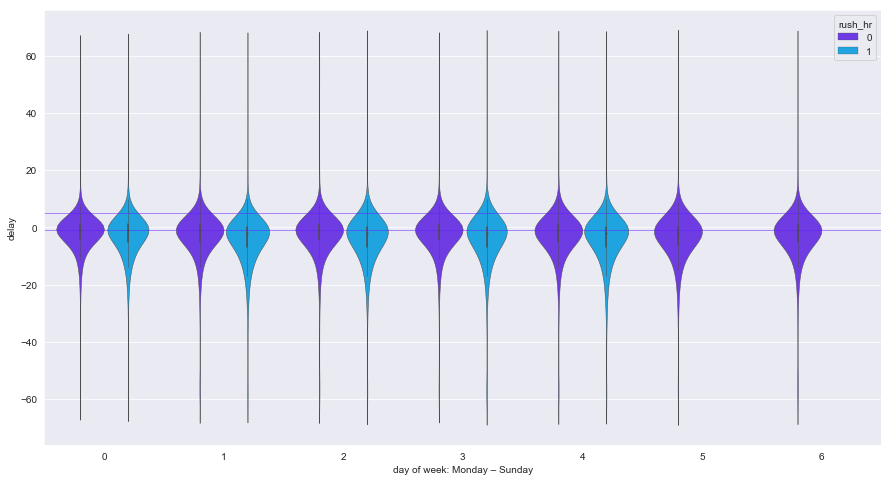

In [38]:
plt.figure(figsize=(15,8))
sns.violinplot(x='day_of_week', y='delay', hue='rush_hr', data=bus, linewidth=.5, bw=.5)
plt.xlabel('day of week: Monday – Sunday')
plt.axhline(y=5, linewidth=.5)
plt.axhline(y=-1, linewidth=.5)
plt.show()

In [39]:
bus['weekend'] = np.where(bus.day_of_week>4,1,0)

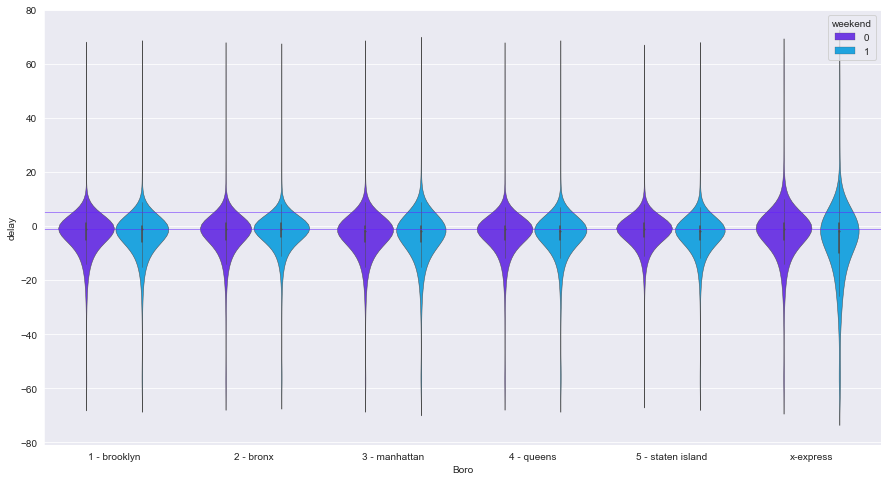

In [40]:
plt.figure(figsize=(15,8))
sns.violinplot(x='boro', y='delay', hue='weekend', data=bus, linewidth=.5, bw=.5)
plt.xlabel('Boro')
plt.axhline(y=5, linewidth=.5)
plt.axhline(y=-1, linewidth=.5)
plt.show()

In [41]:
bus[bus['boro']=='x-express'].describe()

,RecordedAtTime,DirectionRef,OriginLat,OriginLong,DestinationLat,DestinationLong,VehicleLocation.Latitude,VehicleLocation.Longitude,ExpectedArrivalTime,ScheduledArrivalTime,day_of_week,delay,on_time,boro_code,express,sbs,bus_code,line_avg_delay,rush_hr,weekend
count,39739.000000,39739.000000,39739.000000,39739.000000,39739.000000,39739.000000,39739.000000,39739.000000,39739.000000,39739.000000,39739.000000,39739.000000,39739.00000,39739.0,39739.0,39739.0,39739.000000,39739.000000,39739.000000,39739.000000
mean,1013.028511,0.458894,40.659410,-74.059090,40.674531,-74.044785,40.667986,-74.042515,1043.921135,1045.003171,2.082337,-2.864013,0.48280,5.0,1.0,0.0,219.547321,-2.864013,0.544503,0.082941
std,673.815641,0.498314,0.093898,0.106669,0.091320,0.104342,0.073313,0.083056,662.923558,662.690539,1.745774,9.917932,0.49971,0.0,0.0,0.0,9.588855,1.092502,0.498022,0.275797
min,0.000000,0.000000,40.506880,-74.232980,40.508104,-74.230071,40.502898,-74.252318,0.000000,0.000000,0.000000,-60.000000,0.00000,5.0,1.0,0.0,208.000000,-4.519809,0.000000,0.000000
25%,612.000000,0.000000,40.560760,-74.171091,40.564227,-74.165755,40.604303,-74.109239,632.000000,633.000000,0.000000,-5.000000,0.00000,5.0,1.0,0.0,210.000000,-3.663664,0.000000,0.000000
50%,848.000000,0.000000,40.640133,-74.012714,40.716379,-73.991779,40.685557,-74.013901,911.000000,911.000000,2.000000,-1.000000,0.00000,5.0,1.0,0.0,217.000000,-2.773185,1.000000,0.000000
75%,1712.000000,1.000000,40.760430,-73.977491,40.759917,-73.972702,40.737544,-73.989329,1718.000000,1717.000000,4.000000,1.000000,1.00000,5.0,1.0,0.0,227.000000,-2.169598,1.000000,0.000000
max,2358.000000,1.000000,40.770035,-73.701868,40.770593,-73.701382,40.780723,-73.701491,2359.000000,2359.000000,6.000000,60.000000,1.00000,5.0,1.0,0.0,238.000000,0.243202,1.000000,1.000000


In [42]:
bus = bus.drop(bus[bus['boro']=='x-express'].index)

bus.shape

(960261, 30)

In [43]:
bus['date'].value_counts()

2017-10-16    42022
2017-10-05    41855
2017-10-02    40669
2017-10-06    38989
2017-10-10    38865
2017-10-30    38805
2017-10-09    38489
2017-10-27    37604
2017-10-25    37271
2017-10-31    35518
2017-10-04    34840
2017-10-23    34786
2017-10-18    34663
2017-10-11    32715
2017-10-26    31996
2017-10-17    31641
2017-10-12    31102
2017-10-20    30324
2017-10-03    29266
2017-10-21    29034
2017-10-13    26749
2017-10-28    26648
2017-10-19    26105
2017-10-14    24464
2017-10-22    24142
2017-10-15    23951
2017-10-01    23247
2017-10-24    22938
2017-10-07    20015
2017-10-08    17654
2017-10-29    13894
Name: date, dtype: int64

In [44]:
bus.ArrivalProximityText.value_counts().head(10)

approaching       378831
< 1 stop away     322520
at stop           237592
0.6 miles away      5434
0.5 miles away      3788
0.7 miles away      3381
0.8 miles away      1606
1.0 miles away      1158
0.9 miles away      1148
1.1 miles away       496
Name: ArrivalProximityText, dtype: int64

In [45]:
bus.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'RecordedAtDateTime', 'day_of_week', 'date',
       'delay', 'on_time', 'boro', 'boro_code', 'express', 'sbs', 'bus_code',
       'line_avg_delay', 'rush_hr', 'weekend'],
      dtype='object')

In [46]:
bus['day_of_week']

bus.day_of_week.value_counts()

0    194771
1    158228
2    139489
4    133666
3    131058
6    102888
5    100161
Name: day_of_week, dtype: int64

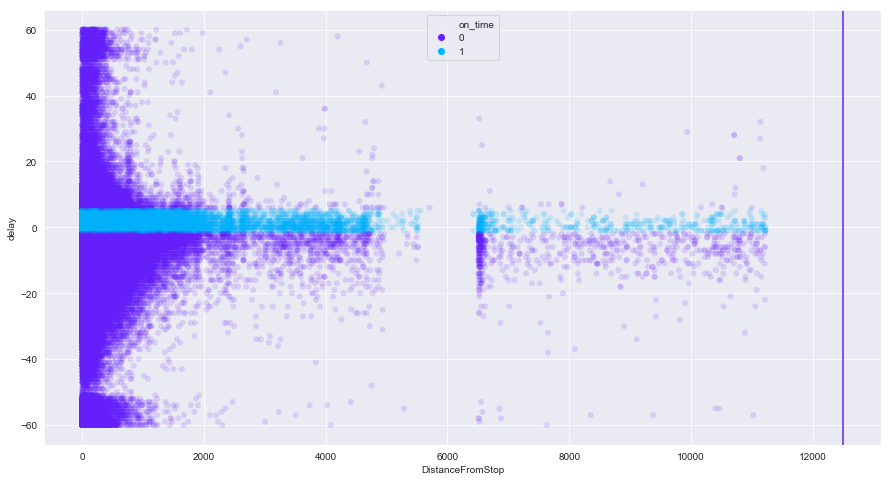

In [47]:
bus["DistanceFromStop"] = pd.to_numeric(bus["DistanceFromStop"])
plt.figure(figsize=(15,8))
sns.scatterplot(x="DistanceFromStop", y="delay", hue='on_time',
                linewidth=0, data=bus, alpha=.15)
plt.axvline(x=12500)
plt.show()

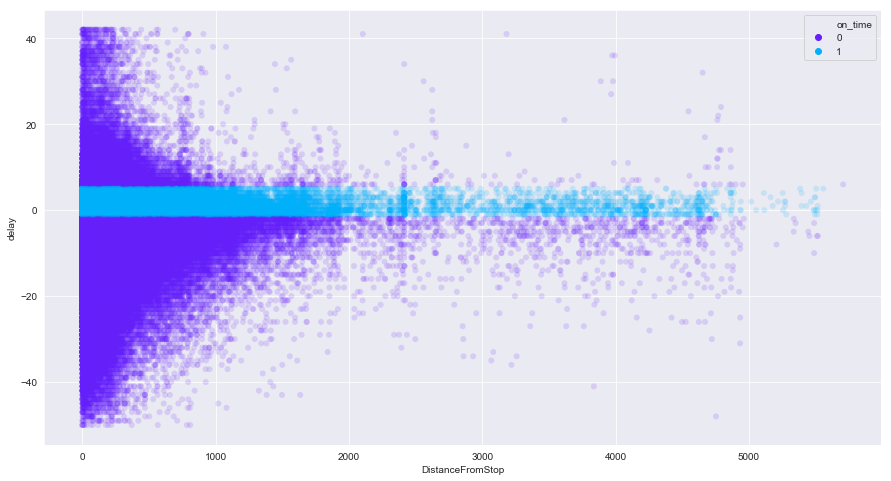

In [48]:
bus = bus.drop(bus[bus['DistanceFromStop']>6000].index)
bus = bus.drop(bus[bus['delay']>42].index)
bus = bus.drop(bus[bus['delay']<-50].index)

bus["DistanceFromStop"] = pd.to_numeric(bus["DistanceFromStop"])
plt.figure(figsize=(15,8))
sns.scatterplot(x="DistanceFromStop", y="delay", hue='on_time',
                linewidth=0, data=bus, alpha=.15)
#plt.axvline(x=12500)
plt.show()

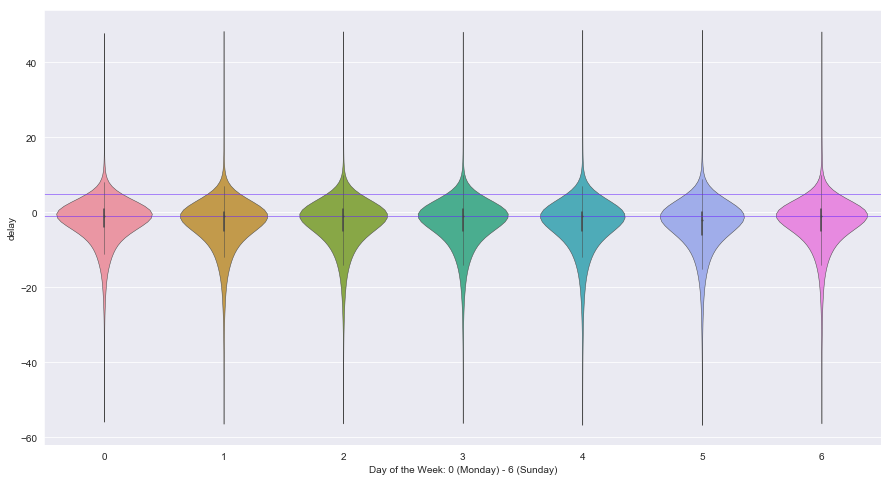

In [49]:
plt.figure(figsize=(15,8))
sns.violinplot(x='day_of_week', y='delay', data=bus, linewidth=.5, bw=.5)
plt.xlabel(('Day of the Week: 0 (Monday) - 6 (Sunday)'))
plt.axhline(y=5, linewidth=.5)
plt.axhline(y=-1, linewidth=.5)
plt.show()

In [50]:
#seller = mel_raw.groupby('SellerG')['Price'].nunique().sort_values(ascending=False).head(40)
seller_plt = pd.DataFrame(bus[['PublishedLineName','delay', 'on_time']].groupby('PublishedLineName')['delay'].mean().sort_values(ascending=False))
seller_plt.reset_index(level=0, inplace=True)
seller_plt.sort_values(by='delay', ascending=True).head(10)

,PublishedLineName,delay
207,S86,-7.906977
206,S84,-7.296703
205,M1,-5.911177
204,Q56,-5.649912
203,S81,-5.622449
202,B35,-5.528730
201,M5,-5.217507
200,Bx32,-4.975241
199,M2,-4.947130
198,M7,-4.877533


In [51]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949343 entries, 0 to 999999
Data columns (total 30 columns):
RecordedAtTime               949343 non-null float64
DirectionRef                 949343 non-null int64
PublishedLineName            949343 non-null category
OriginName                   949343 non-null object
OriginLat                    949343 non-null float64
OriginLong                   949343 non-null float64
DestinationName              949343 non-null object
DestinationLat               949343 non-null float64
DestinationLong              949343 non-null float64
VehicleRef                   949343 non-null object
VehicleLocation.Latitude     949343 non-null float64
VehicleLocation.Longitude    949343 non-null float64
NextStopPointName            949343 non-null object
ArrivalProximityText         949343 non-null object
DistanceFromStop             949343 non-null int64
ExpectedArrivalTime          949343 non-null float64
ScheduledArrivalTime         949343 non-null floa

In [52]:
bus['OriginName'].value_counts().head()

MERRICK BL/ARCHER AV    13645
E 126 ST/2 AV           13284
W 179 ST/BROADWAY       12840
TEARDROP/LAYOVER        10104
KINGS PLAZA              9878
Name: OriginName, dtype: int64

In [53]:
bus.loc[bus['on_time']==0].VehicleRef.value_counts()

NYCT_5816    256
NYCT_5845    247
NYCT_5906    246
NYCT_5912    245
NYCT_6023    243
NYCT_5310    242
NYCT_6051    241
NYCT_6037    239
NYCT_6039    239
NYCT_5902    235
NYCT_5820    234
NYCT_5261    233
NYCT_5321    233
NYCT_5858    232
NYCT_6116    231
NYCT_6043    229
NYCT_4582    229
NYCT_6003    228
NYCT_6063    227
NYCT_5798    226
NYCT_7364    225
NYCT_5253    224
NYCT_6020    223
NYCT_5853    223
NYCT_5309    223
NYCT_4118    222
NYCT_6118    222
NYCT_6047    222
NYCT_6065    222
NYCT_6002    221
            ... 
NYCT_8473      4
NYCT_4473      4
NYCT_4868      4
NYCT_7349      3
NYCT_2549      3
NYCT_2514      3
NYCT_2693      3
NYCT_2544      3
NYCT_2683      2
NYCT_4469      2
NYCT_7794      2
NYCT_7390      2
NYCT_1271      2
NYCT_7338      2
NYCT_5935      2
NYCT_2562      2
NYCT_2637      1
NYCT_5565      1
NYCT_5884      1
NYCT_2540      1
NYCT_2761      1
NYCT_2774      1
NYCT_2546      1
NYCT_2543      1
NYCT_2569      1
NYCT_2684      1
NYCT_2597      1
NYCT_2710     

In [54]:
bus.VehicleRef = bus.VehicleRef.map(lambda x: x.lstrip('NYCT_'))
bus.VehicleRef = pd.to_numeric(bus.VehicleRef)
bus.VehicleRef.describe()

count    949343.000000
mean       5296.665468
std        2290.579795
min         230.000000
25%        4347.000000
50%        5677.000000
75%        7063.000000
max        9674.000000
Name: VehicleRef, dtype: float64

In [55]:
vehavgdelays = pd.DataFrame(bus.groupby('VehicleRef')['delay'].mean().sort_values(ascending=False))
vehavgdelays.columns = ['veh_avg_delay']

#vehavgdelays

bus = bus.merge(vehavgdelays, on='VehicleRef', how='inner')
bus.head()

,RecordedAtTime,DirectionRef,PublishedLineName,OriginName,OriginLat,OriginLong,DestinationName,DestinationLat,DestinationLong,VehicleRef,...,on_time,boro,boro_code,express,sbs,bus_code,line_avg_delay,rush_hr,weekend,veh_avg_delay
0,1351.0,0,Bx9,E TREMONT AV/E 177 ST,40.839994,-73.879938,RIVERDALE 262 ST,40.910081,-73.896495,5696,...,0,2 - bronx,1,0,0,96,-2.321765,0,1,-3.155844
1,1721.0,1,Bx9,BROADWAY/W 262 ST,40.910104,-73.896730,WEST FARMS,40.840642,-73.879807,5696,...,1,2 - bronx,1,0,0,96,-2.321765,0,1,-3.155844
2,1842.0,0,Bx9,E TREMONT AV/E 177 ST,40.839994,-73.879938,RIVERDALE 262 ST,40.910081,-73.896495,5696,...,0,2 - bronx,1,0,0,96,-2.321765,1,0,-3.155844
3,1652.0,0,Bx9,E TREMONT AV/E 177 ST,40.839994,-73.879938,RIVERDALE 262 ST,40.910081,-73.896495,5696,...,0,2 - bronx,1,0,0,96,-2.321765,1,0,-3.155844
4,519.0,1,Bx9,W 225 ST/BROADWAY,40.874274,-73.909375,WEST FARMS,40.840642,-73.879807,5696,...,1,2 - bronx,1,0,0,96,-2.321765,0,0,-3.155844


Location calculated from Tom's comment here: https://stackoverflow.com/questions/4637031/geospatial-indexing-with-redis-sinatra-for-a-facebook-app

In [56]:
bus['vehical_location'] = (bus['VehicleLocation.Latitude']+90)*180+bus['VehicleLocation.Longitude'] 
bus['destination_location'] = (bus['DestinationLat']+90)*180+bus['DestinationLong']
bus['origin_location'] = (bus['OriginLat']+90)*180+bus['OriginLong']

In [57]:
cent_park = int(round((40.7829+90)*180+(-73.9654)))
prosp_park = int(round((40.6602+90)*180+(-73.9690)))
flushing_mead = int(round((40.7397+90)*180+(-73.8408)))
fordham = int(round((40.8620+90)*180+(-73.8857)))
wagner = int(round((40.6150+90)*180+(-74.0944)))
print(cent_park, prosp_park, flushing_mead, fordham, wagner)

23467 23445 23459 23481 23437


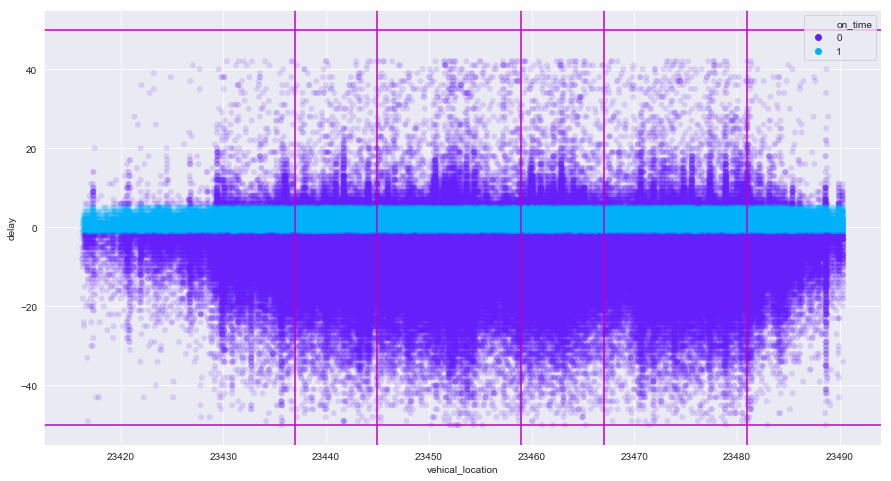

In [58]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='vehical_location', y='delay', hue='on_time',
                linewidth=0, data=bus, alpha=.15)
plt.axvline(x=cent_park, color='m', label='central park')
plt.axvline(x=prosp_park, color='m', label='prospect park')
plt.axvline(x=flushing_mead, color='m', label='flushing meadows')
plt.axvline(x=fordham, color='m', label='fordham')
plt.axvline(x=wagner, color='m', label='wagner college')
plt.axhline(y=-50, color='m')
plt.axhline(y=50, color='m')
plt.show()

In [59]:
bus.shape

(949343, 34)

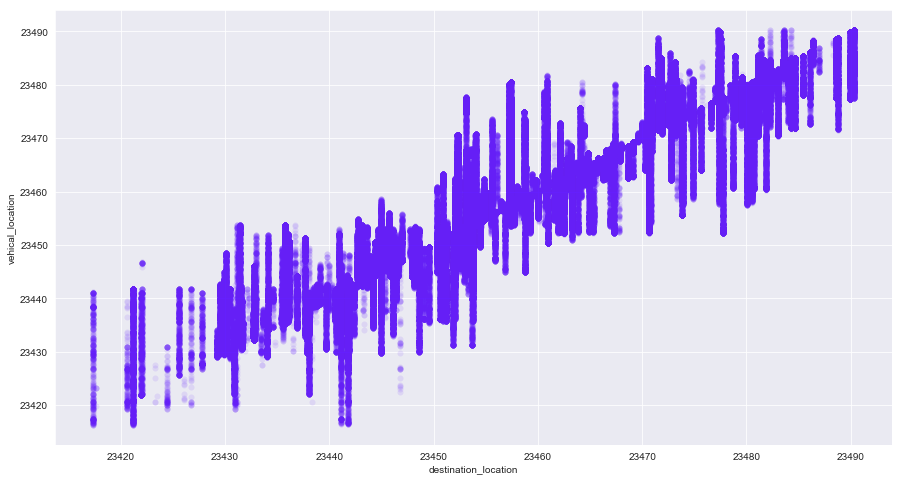

In [60]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='destination_location', y='vehical_location',
                linewidth=0, data=bus.loc[bus.on_time==0], alpha=.1)
plt.show()

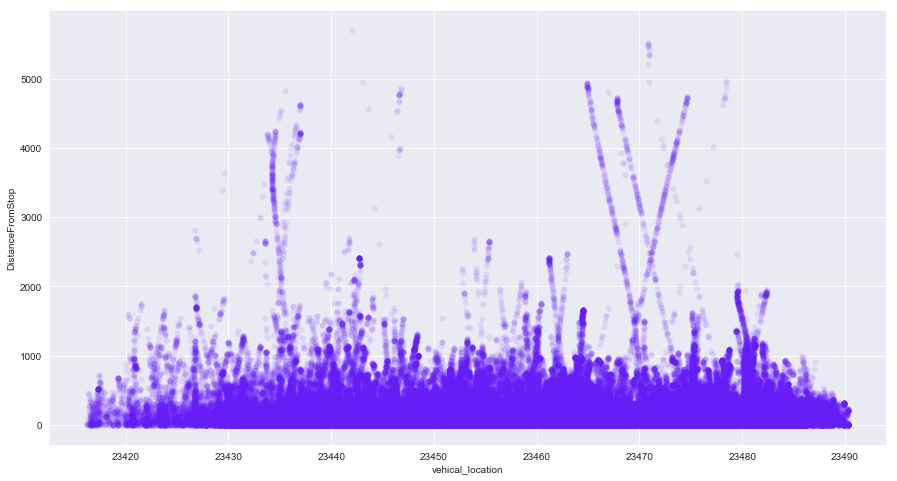

In [61]:
plt.figure(figsize=(15,8))
sns.scatterplot(x='vehical_location', y='DistanceFromStop',
                linewidth=0, data=bus.loc[bus.on_time==0], alpha=.1)
plt.show()

In [62]:
bus.columns

Index(['RecordedAtTime', 'DirectionRef', 'PublishedLineName', 'OriginName',
       'OriginLat', 'OriginLong', 'DestinationName', 'DestinationLat',
       'DestinationLong', 'VehicleRef', 'VehicleLocation.Latitude',
       'VehicleLocation.Longitude', 'NextStopPointName',
       'ArrivalProximityText', 'DistanceFromStop', 'ExpectedArrivalTime',
       'ScheduledArrivalTime', 'RecordedAtDateTime', 'day_of_week', 'date',
       'delay', 'on_time', 'boro', 'boro_code', 'express', 'sbs', 'bus_code',
       'line_avg_delay', 'rush_hr', 'weekend', 'veh_avg_delay',
       'vehical_location', 'destination_location', 'origin_location'],
      dtype='object')

In [63]:
bus.DestinationName.value_counts().head()

WASHINGTON HTS GW BRIDGE    14112
ST GEORGE FERRY              9122
FLUSHING  MAIN ST STA        8258
W FARMS RD SOUTHERN BL       7984
FLUSHING MAIN ST STA         6137
Name: DestinationName, dtype: int64

In [64]:
# calculate the route distance basec upon destination & origin 
# from here: https://www.varsitytutors.com/hotmath/hotmath_help/topics/distance-formula
import math
import geopy.distance
from tqdm import tqdm, tqdm_notebook
tqdm.pandas()

destination = (bus.DestinationLat, bus.DestinationLong)
origin = (bus.OriginLat, bus.OriginLong)
location = (bus['VehicleLocation.Latitude'], bus['VehicleLocation.Longitude'])
bus['route_length'] = bus.progress_apply(lambda x: geopy.distance.geodesic((x['DestinationLat'], x['DestinationLong']), (x['OriginLat'], x['OriginLong'])).miles, axis = 1)
bus['distance_into_route'] = bus.progress_apply(lambda x: geopy.distance.geodesic((x['VehicleLocation.Latitude'], x['VehicleLocation.Longitude']), (x['OriginLat'], x['OriginLong'])).miles, axis = 1)

bus['percent_into_route'] = bus['distance_into_route'] / bus['route_length']

bus[['PublishedLineName','OriginName','NextStopPointName','route_length','distance_into_route','percent_into_route']].tail(120)

100%|██████████| 949343/949343 [05:43<00:00, 2765.47it/s]


,PublishedLineName,OriginName,NextStopPointName,route_length,distance_into_route,percent_into_route
949223,Bx6-SBS,RIVERSIDE DR W/157-10 RIVERSIDE DR W,E 161 ST/MELROSE AV,4.187761,1.674267,0.399800
949224,Bx6-SBS,RIVERSIDE DR W/157-10 RIVERSIDE DR W,HALLECK ST/HUNTS PT AV,4.187761,3.802287,0.907952
949225,Bx6-SBS,RIVERSIDE DR W/157-10 RIVERSIDE DR W,E 161 ST/MELROSE AV,4.187761,1.681808,0.401601
949226,Bx6-SBS,RIVERSIDE DR W/157-10 RIVERSIDE DR W,HALLECK ST/SPOFFORD AV,4.187761,3.572132,0.852993
949227,Bx6-SBS,FOOD CENTER DR/MARKET ST,E 161 ST/MELROSE AV,4.177160,2.142389,0.512882
949228,Bx6-SBS,RIVERSIDE DR W/157-10 RIVERSIDE DR W,HUNTS POINT AV/COSTER ST,4.187761,3.331827,0.795611
949229,Bx6-SBS,RIVERSIDE DR W/157-10 RIVERSIDE DR W,FOOD CENTER DR/MARKET ST,4.187761,4.279589,1.021928
949230,Bx6-SBS,FOOD CENTER DR/MARKET ST,W 155 ST/AMSTERDAM AV,4.177160,3.422933,0.819440
949231,Bx6-SBS,FOOD CENTER DR/MARKET ST,E 161 ST/MELROSE AV,4.177160,2.154378,0.515752
949232,Bx6-SBS,FOOD CENTER DR/MARKET ST,E 163 ST/3 AV,4.177160,1.574726,0.376985


In [65]:
bus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 949343 entries, 0 to 949342
Data columns (total 37 columns):
RecordedAtTime               949343 non-null float64
DirectionRef                 949343 non-null int64
PublishedLineName            949343 non-null category
OriginName                   949343 non-null object
OriginLat                    949343 non-null float64
OriginLong                   949343 non-null float64
DestinationName              949343 non-null object
DestinationLat               949343 non-null float64
DestinationLong              949343 non-null float64
VehicleRef                   949343 non-null int64
VehicleLocation.Latitude     949343 non-null float64
VehicleLocation.Longitude    949343 non-null float64
NextStopPointName            949343 non-null object
ArrivalProximityText         949343 non-null object
DistanceFromStop             949343 non-null int64
ExpectedArrivalTime          949343 non-null float64
ScheduledArrivalTime         949343 non-null float

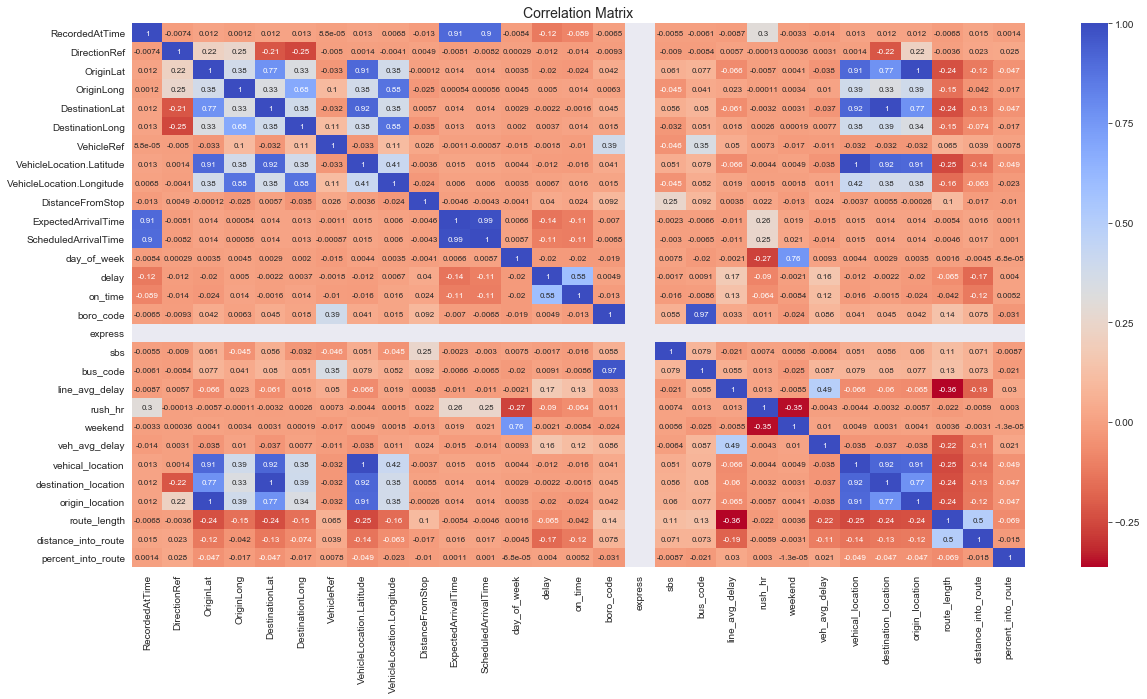

In [66]:
plt.figure(figsize=(20,10))
sample_corr = bus.corr()
sns.heatmap(sample_corr, cmap='coolwarm_r', annot=True, annot_kws={'size':8})
plt.title('Correlation Matrix', fontsize=14)
plt.show()

In [67]:
# add AUC to the models

In [68]:
bus.dtypes

RecordedAtTime                      float64
DirectionRef                          int64
PublishedLineName                  category
OriginName                           object
OriginLat                           float64
OriginLong                          float64
DestinationName                      object
DestinationLat                      float64
DestinationLong                     float64
VehicleRef                            int64
VehicleLocation.Latitude            float64
VehicleLocation.Longitude           float64
NextStopPointName                    object
ArrivalProximityText                 object
DistanceFromStop                      int64
ExpectedArrivalTime                 float64
ScheduledArrivalTime                float64
RecordedAtDateTime           datetime64[ns]
day_of_week                           int64
date                                 object
delay                               float64
on_time                               int64
boro                            

## Modeling

In [69]:
from sklearn.feature_selection import SelectKBest, f_classif

X = bus.drop(['PublishedLineName', 'OriginName','DestinationName', 'NextStopPointName',
              'ArrivalProximityText','boro','date','ExpectedArrivalTime', 'delay','on_time','RecordedAtDateTime'], 1)
y = bus['on_time']

selector=SelectKBest(score_func=f_classif,k=26)
selector.fit(X,y)
scores = pd.DataFrame()
scores["Attribute"] = X.columns
scores["F Score"] = selector.scores_
scores["P Value"] = selector.pvalues_
scores["Support"] = selector.get_support()

scores = scores.sort_values(by=['F Score'], ascending=False)

key_vals = scores.Attribute.loc[scores['F Score']>100].values

scores.loc[scores['P Value']<.05].reset_index()

/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [13] are constant.
  UserWarning)
/usr/local/lib/python3.7/site-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw


,index,Attribute,F Score,P Value,Support
0,16,line_avg_delay,16948.231462,0.000000e+00,True
1,24,distance_into_route,14627.996248,0.000000e+00,True
2,19,veh_avg_delay,12857.922009,0.000000e+00,True
3,10,ScheduledArrivalTime,11648.756011,0.000000e+00,True
4,0,RecordedAtTime,7599.470048,0.000000e+00,True
5,17,rush_hr,3911.988626,0.000000e+00,True
6,23,route_length,1640.624392,0.000000e+00,True
7,2,OriginLat,567.421540,2.224031e-125,True
8,22,origin_location,561.402999,4.524595e-124,True
9,9,DistanceFromStop,535.402068,2.035189e-118,True


In [70]:
X = bus[key_vals]
y = bus['on_time']

from sklearn import preprocessing

#from sklearn.preprocessing import StandardScaler
#scaler = StandardScaler()
#scaler.fit(X,y)

X = preprocessing.scale(X)
#y = StandardScaler().fit_transform(y)

# to split a training and test sample
from sklearn.model_selection import train_test_split, cross_val_score
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype int8, int64, float64 were all converted to float64 by the scale function.
  # Remove the CWD from sys.path while we load stuff.


### Logistic Regression

In [71]:
# How long will it take
from datetime import datetime
start_time = datetime.now()

# get rid of the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e9, max_iter = 150)
lr.fit(x_train, y_train)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

print('Train Percentage accuracy:')
print(lr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(lr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(lr, x_train, y_train, cv = 5))

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Train Percentage accuracy:
0.5959941405070456

Test Percentage accuracy:
0.5958809451579196

Cross Validation:
[0.59566579 0.59686662 0.59598598 0.59555059 0.59597194]

Classification Report:

              precision    recall  f1-score   support

           0       0.60      0.56      0.58    117483
           1       0.59      0.63      0.61    119853

   micro avg       0.60      0.60      0.60    237336
   macro avg       0.60      0.60      0.60    237336
weighted avg       0.60      0.60      0.60    237336


Duration: 0:00:17.738616


In [82]:
start_time = datetime.now()
# get rid of the warnings
import warnings
warnings.filterwarnings("ignore")

# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'C':[1e9,.5,1,3,5,10], 'max_iter':[50,100,150,300,500], 'penalty':['l1','l2']}

# Start the grid search again
grid_DT = GridSearchCV(lr, param_grid, cv=2, verbose=1, n_jobs=-1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:')
print(grid_DT.best_params_)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

print('Train Percentage accuracy:')
print(lr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(lr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(lr, x_train, y_train, cv = 3))

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Fitting 2 folds for each of 60 candidates, totalling 120 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   24.0s


KeyboardInterrupt: 

### Naive Bayes

In [72]:
start_time = datetime.now()

from sklearn.naive_bayes import BernoulliNB
bnb = BernoulliNB()
bnb.fit(x_train, y_train)
# Set Up Predictor
ypred_bnb = bnb.predict(x_test)

print('\nTrain Percentage accuracy:')
print(bnb.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(bnb.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(bnb, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_bnb))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.5767668014499857

Test Percentage accuracy:
0.577413456028584

Cross Validation:
[0.57568012 0.57689499 0.57732741 0.57659005 0.5770114 ]

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.55      0.56    117483
           1       0.58      0.60      0.59    119853

   micro avg       0.58      0.58      0.58    237336
   macro avg       0.58      0.58      0.58    237336
weighted avg       0.58      0.58      0.58    237336


Duration: 0:00:03.183216


### K Nearest Neighbors

In [ ]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=300)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

In [85]:
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest
param_grid = {'n_neighbors':[20,30,50,75,150,300,500,750,1000]}

# Start the grid search again
grid_DT = GridSearchCV(knn, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

Fitting 2 folds for each of 7 candidates, totalling 14 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  14 out of  14 | elapsed: 49.7min finished


Best score for data: {'n_neighbors': 50}


In [ ]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=50)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

### Decision Tree

In [73]:
start_time = datetime.now()
from sklearn import tree

dec_tr = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=20,
    random_state = 1337
)

dec_tr.fit(x_train, y_train)
# Set Up Predictor
ypred_dec_tr = dec_tr.predict(x_test)

print('\nTrain Percentage accuracy:')
print(dec_tr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(dec_tr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(dec_tr, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_dec_tr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.7093624079538544

Test Percentage accuracy:
0.6047797215761621

Cross Validation:
[0.59650145 0.59900844 0.59319808 0.60101404 0.59637222]

Classification Report:

              precision    recall  f1-score   support

           0       0.61      0.57      0.59    117483
           1       0.60      0.64      0.62    119853

   micro avg       0.60      0.60      0.60    237336
   macro avg       0.60      0.60      0.60    237336
weighted avg       0.60      0.60      0.60    237336


Duration: 0:00:08.555898


### Gradient Boosted Decision Tree

In [ ]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='exponential', max_depth=5 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

In [ ]:
#GridSearchCV for random forest 
param_grid = {'n_estimators':[50,100,200,300,500,750,1000], 'max_depth':[6,10,20,30],
              'loss':['deviance', 'exponential']}

# Start the grid search again
grid_DT = GridSearchCV(clf, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

### Random Forest

In [75]:
start_time = datetime.now()
from sklearn import ensemble

rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6248744745487053

Test Percentage accuracy:
0.6210815047021944

Cross Validation:
[0.61954186 0.62202076 0.62142822 0.6206066  0.62030463]

Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.60      0.61    117483
           1       0.62      0.64      0.63    119853

   micro avg       0.62      0.62      0.62    237336
   macro avg       0.62      0.62      0.62    237336
weighted avg       0.62      0.62      0.62    237336


Duration: 0:07:29.206994


In [ ]:
# Grid Search CV for decision tree
from sklearn.model_selection import GridSearchCV

#GridSearchCV for random forest 
param_grid = {'n_estimators':[50,75,100,125,150,200,300], 'max_depth':[4,6,8,10]}

# Start the grid search again
grid_DT = GridSearchCV(rfc, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

### With PCA

In [78]:
# Standardizing the features
from sklearn.preprocessing import StandardScaler
X = StandardScaler().fit_transform(X)

In [82]:
from sklearn.decomposition import PCA
pca = PCA(n_components=5)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['pc1', 'pc2', 'pc3', 'pc4', 'pc5'])

print(pca.explained_variance_ratio_)

[0.23994364 0.10283654 0.09800389 0.09327836 0.07345767]


In [83]:
X = principalDf[['pc1', 'pc2', 'pc3', 'pc4', 'pc5']]
y = bus['on_time']

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0)

### Logistic Regression

In [84]:
# How long will it take
from datetime import datetime
start_time = datetime.now()

# get rid of the warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1e9, max_iter = 150)
lr.fit(x_train, y_train)

# Set Up Predictor
ypred_lr = lr.predict(x_test)

print('Train Percentage accuracy:')
print(lr.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(lr.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(lr, x_train, y_train, cv = 5))

from sklearn.metrics import classification_report
print('\nClassification Report:\n')
print(classification_report(y_test, ypred_lr))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

Train Percentage accuracy:
0.5784999304782116

Test Percentage accuracy:
0.5787196211278525

Cross Validation:
[0.57852418 0.57902979 0.57914621 0.57762235 0.57844397]

Classification Report:

              precision    recall  f1-score   support

           0       0.58      0.54      0.56    117483
           1       0.58      0.62      0.60    119853

   micro avg       0.58      0.58      0.58    237336
   macro avg       0.58      0.58      0.58    237336
weighted avg       0.58      0.58      0.58    237336


Duration: 0:00:04.046802


### KNN

In [85]:
start_time = datetime.now()

from sklearn import neighbors
knn = neighbors.KNeighborsClassifier(n_neighbors=30)
knn.fit(x_train, y_train)
# Set Up Predictor
ypred_knn = knn.predict(x_test)

print('\nTrain Percentage accuracy:')
print(knn.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(knn.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(knn, x_train, y_train, cv = 5))

print('\nClassification Report:\n')
print(classification_report(y_test, ypred_knn))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))


Train Percentage accuracy:
0.6373139589919762

Test Percentage accuracy:
0.6000480331681667

Cross Validation:
[0.59539192 0.59484417 0.59700423 0.59589469 0.59680058]

Classification Report:

              precision    recall  f1-score   support

           0       0.59      0.62      0.60    117483
           1       0.61      0.58      0.60    119853

   micro avg       0.60      0.60      0.60    237336
   macro avg       0.60      0.60      0.60    237336
weighted avg       0.60      0.60      0.60    237336


Duration: 0:01:36.826391


### Gradient Boosted Decision Tree

In [ ]:
start_time = datetime.now()
from sklearn import ensemble

clf = ensemble.GradientBoostingClassifier(loss='exponential', max_depth=5 , n_estimators=50 )
clf.fit(x_train, y_train)

ypred_clf = clf.predict(x_test)

print('\nTrain Percentage accuracy:')
print(clf.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(clf.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(clf, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_clf))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

In [ ]:
#GridSearchCV for random forest 
param_grid = {'n_estimators':[50,100,200,300,500,750,1000], 'max_depth':[6,10,20,30],
              'loss':['deviance', 'exponential']}

# Start the grid search again
grid_DT = GridSearchCV(clf, param_grid, cv=2, verbose=1)

grid_DT.fit(x_train, y_train)

# summarize the results of the grid search
# View the accuracy score
print('Best score for data:', grid_DT.best_params_)

### Random Forest

In [ ]:
start_time = datetime.now()
rfc = ensemble.RandomForestClassifier(n_estimators=50, max_depth=8)
rfc.fit(x_train, y_train)

ypred_rfc = rfc.predict(x_test)

print('\nTrain Percentage accuracy:')
print(rfc.score(x_train, y_train))

print('\nTest Percentage accuracy:')
print(rfc.score(x_test, y_test))

print('\nCross Validation:')
print(cross_val_score(rfc, x_train, y_train, cv = 5))

print('\nClassification Report:')
print(classification_report(y_test, ypred_rfc))

end_time = datetime.now()
print('\nDuration: {}'.format(end_time - start_time))

# 